In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
#import folium as fm
import matplotlib.pyplot as plt
from pylab import *            
import os
import json
import requests
#import geopandas as gpd
#from branca.colormap import linear
from pprint import pprint
from time import time
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB as GNB, MultinomialNB as MNB, ComplementNB as CNB, BernoulliNB as BNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_validate, cross_val_score as cvscore
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from scipy import stats

In [2]:
data = pd.read_csv("flights.csv",low_memory=False)

In [4]:
data

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,688,N657JB,LAX,BOS,2359,...,753.0,-26.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819075,2015,12,31,4,B6,745,N828JB,JFK,PSE,2359,...,430.0,-16.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819076,2015,12,31,4,B6,1503,N913JB,JFK,SJU,2359,...,432.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5819077,2015,12,31,4,B6,333,N527JB,MCO,SJU,2359,...,330.0,-10.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


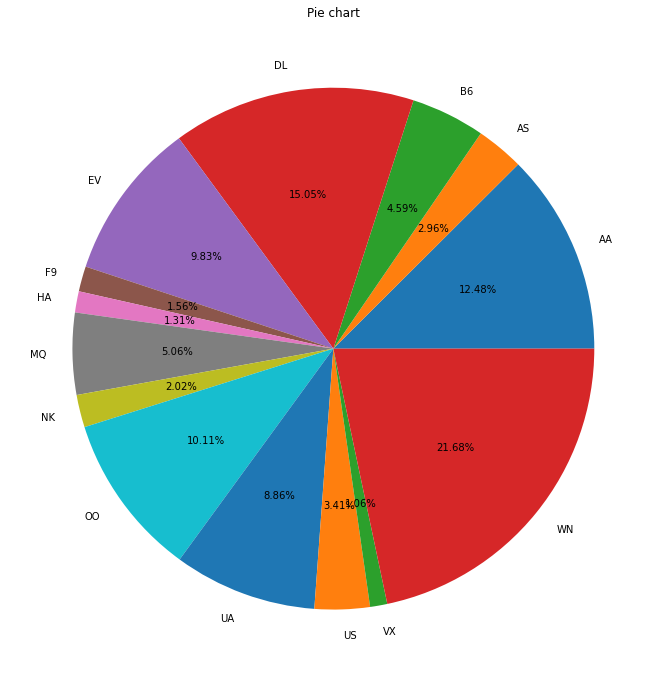

In [5]:
X = data.groupby(data["AIRLINE"]).count().YEAR         #creat pie chart of all airports
labels=X.index
fig = plt.figure(figsize=(12,12))
plt.pie(X,labels=labels,autopct='%1.2f%%')       
plt.title("Pie chart")
plt.show()  

In [3]:
ndf = data.loc[:,['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED']].copy()   


In [4]:
ndf = ndf.dropna()
ndf.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
count,5714008.0,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5.714008e+06,5714008.0,5714008.0
mean,2015.0,6.547799e+00,1.570759e+01,3.932643e+00,1.328907e+03,1.335066e+03,9.294842e+00,1.606550e+01,1.357099e+03,1.418940e+02,1.370062e+02,1.135116e+02,8.244569e+02,1.471319e+03,7.429063e+00,1.493187e+03,1.476373e+03,4.407057e+00,0.0,0.0
std,0.0,3.397421e+00,8.774394e+00,1.985967e+00,4.835251e+02,4.964198e+02,3.688972e+01,8.882449e+00,4.980237e+02,7.531400e+01,7.421107e+01,7.223082e+01,6.086620e+02,5.218682e+02,5.618951e+00,5.069011e+02,5.259730e+02,3.927130e+01,0.0,0.0
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.200000e+01,1.000000e+00,1.000000e+00,1.800000e+01,1.400000e+01,7.000000e+00,3.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-8.700000e+01,0.0,0.0
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,9.160000e+02,9.210000e+02,-5.000000e+00,1.100000e+01,9.350000e+02,8.500000e+01,8.200000e+01,6.000000e+01,3.730000e+02,1.054000e+03,4.000000e+00,1.110000e+03,1.058000e+03,-1.300000e+01,0.0,0.0
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.325000e+03,1.330000e+03,-2.000000e+00,1.400000e+01,1.343000e+03,1.230000e+02,1.180000e+02,9.400000e+01,6.500000e+02,1.508000e+03,6.000000e+00,1.520000e+03,1.512000e+03,-5.000000e+00,0.0,0.0
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,1.730000e+03,1.740000e+03,7.000000e+00,1.900000e+01,1.754000e+03,1.740000e+02,1.680000e+02,1.440000e+02,1.065000e+03,1.911000e+03,9.000000e+00,1.917000e+03,1.916000e+03,8.000000e+00,0.0,0.0
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,2.359000e+03,2.400000e+03,1.988000e+03,2.250000e+02,2.400000e+03,7.180000e+02,7.660000e+02,6.900000e+02,4.983000e+03,2.400000e+03,2.480000e+02,2.400000e+03,2.400000e+03,1.971000e+03,0.0,0.0


Text(0, 0.5, 'Number of records')

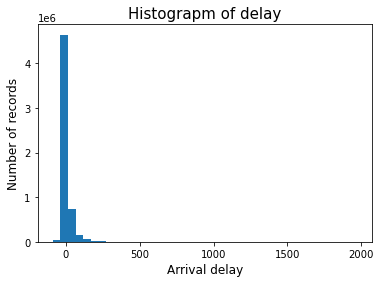

In [8]:
plt.hist(ndf['ARRIVAL_DELAY'],bins =40)
plt.title("Histograpm of delay",fontsize=15)          #处理一下异常值
plt.xlabel("Arrival delay",fontsize=12)
plt.ylabel("Number of records",fontsize=12)


In [5]:
r = list(ndf[ndf['ARRIVAL_DELAY'] >250].index) 
ndf = ndf.drop(index = r)

In [6]:
r1 = list(ndf[ndf['ARRIVAL_DELAY'] < -50].index) 
ndf = ndf.drop(index = r1)

In [11]:
ndf.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED
count,5691852.0,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5.691852e+06,5691852.0,5691852.0
mean,2015.0,6.547962e+00,1.570496e+01,3.932747e+00,1.329025e+03,1.334272e+03,8.107438e+00,1.604819e+01,1.356411e+03,1.417765e+02,1.368873e+02,1.134186e+02,8.236833e+02,1.471506e+03,7.420534e+00,1.493144e+03,1.476646e+03,3.218235e+00,0.0,0.0
std,0.0,3.396784e+00,8.774288e+00,1.985654e+00,4.836150e+02,4.957799e+02,2.915048e+01,8.827094e+00,4.973128e+02,7.519356e+01,7.412577e+01,7.214989e+01,6.078777e+02,5.207207e+02,5.573124e+00,5.069786e+02,5.247728e+02,3.187310e+01,0.0,0.0
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-5.600000e+01,1.000000e+00,1.000000e+00,1.800000e+01,1.400000e+01,7.000000e+00,3.100000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-5.000000e+01,0.0,0.0
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,9.160000e+02,9.200000e+02,-5.000000e+00,1.100000e+01,9.350000e+02,8.500000e+01,8.200000e+01,6.000000e+01,3.730000e+02,1.054000e+03,4.000000e+00,1.110000e+03,1.059000e+03,-1.300000e+01,0.0,0.0
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.325000e+03,1.329000e+03,-2.000000e+00,1.400000e+01,1.342000e+03,1.230000e+02,1.180000e+02,9.400000e+01,6.500000e+02,1.508000e+03,6.000000e+00,1.520000e+03,1.512000e+03,-5.000000e+00,0.0,0.0
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,1.730000e+03,1.739000e+03,7.000000e+00,1.900000e+01,1.753000e+03,1.740000e+02,1.680000e+02,1.440000e+02,1.065000e+03,1.911000e+03,9.000000e+00,1.917000e+03,1.916000e+03,8.000000e+00,0.0,0.0
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,2.359000e+03,2.400000e+03,3.050000e+02,2.000000e+02,2.400000e+03,7.180000e+02,7.660000e+02,6.900000e+02,4.983000e+03,2.400000e+03,2.480000e+02,2.400000e+03,2.400000e+03,2.500000e+02,0.0,0.0


Text(0, 0.5, 'Number of records')

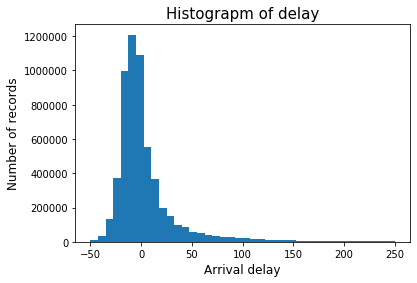

In [11]:
plt.hist(ndf['ARRIVAL_DELAY'],bins =40)
plt.title("Histograpm of delay",fontsize=15)          #处理一下异常值
plt.xlabel("Arrival delay",fontsize=12)
plt.ylabel("Number of records",fontsize=12)

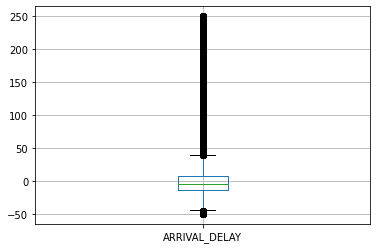

In [12]:
dd = ndf.loc[:,['ARRIVAL_DELAY']].copy()
dd.boxplot()

In [13]:
po = ndf[ndf["ARRIVAL_DELAY"]>0].copy() 
ne = ndf[ndf["ARRIVAL_DELAY"]<0].copy()

In [14]:
po.describe().ARRIVAL_DELAY   

count    2.067765e+06
mean     3.001858e+01
std      3.934909e+01
min      1.000000e+00
25%      6.000000e+00
50%      1.500000e+01
75%      3.700000e+01
max      2.500000e+02
Name: ARRIVAL_DELAY, dtype: float64

In [7]:
IQR =  37-6
big = 1.5*IQR+37

In [8]:
r = list(ndf[ndf['ARRIVAL_DELAY'] > big].index) 
ndf = ndf.drop(index = r)

Text(0, 0.5, 'Number of records')

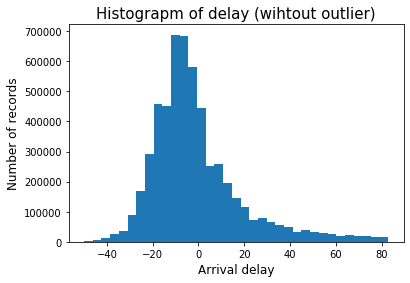

In [17]:
plt.hist(ndf['ARRIVAL_DELAY'],bins =35)
plt.title("Histograpm of delay (wihtout outlier)",fontsize=15)         
plt.xlabel("Arrival delay",fontsize=12)
plt.ylabel("Number of records",fontsize=12)

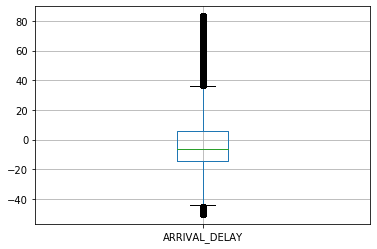

In [18]:
dd = ndf.loc[:,['ARRIVAL_DELAY']].copy()
dd.boxplot()

In [9]:
ndf['trip_speed'] = ndf.DISTANCE/ndf.AIR_TIME
ndf['take_off_hours'] = (ndf.WHEELS_OFF/100).apply(lambda x:int(x))
ndf['delay'] = (ndf.ARRIVAL_DELAY>0)*1     # 延误了就是1 ， 提早到达是0  （classification 就来干这个事情）

In [16]:
ndf.describe()

,YEAR,MONTH,DAY,DAY_OF_WEEK,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,...,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,trip_speed,take_off_hours,delay
count,5501194.0,5.501194e+06,5.501194e+06,5.501194e+06,5.501194e+06,5.501194e+06,5.501194e+06,5.501194e+06,5.501194e+06,5.501194e+06,...,5.501194e+06,5.501194e+06,5.501194e+06,5.501194e+06,5.501194e+06,5501194.0,5501194.0,5.501194e+06,5.501194e+06,5.501194e+06
mean,2015.0,6.558939e+00,1.570699e+01,3.937399e+00,1.322897e+03,1.324145e+03,3.952668e+00,1.583706e+01,1.346811e+03,1.417568e+02,...,1.469425e+03,7.359752e+00,1.487420e+03,1.475161e+03,-1.247273e+00,0.0,0.0,6.815283e+00,1.318121e+01,3.412181e-01
std,0.0,3.397681e+00,8.775288e+00,1.984627e+00,4.838191e+02,4.915674e+02,1.680831e+01,8.127936e+00,4.925571e+02,7.527084e+01,...,5.118564e+02,5.256606e+00,5.060950e+02,5.154858e+02,1.994138e+01,0.0,0.0,1.153202e+00,4.925711e+00,4.741185e-01
min,2015.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-5.600000e+01,1.000000e+00,1.000000e+00,1.800000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-5.000000e+01,0.0,0.0,7.380952e-01,0.000000e+00,0.000000e+00
25%,2015.0,4.000000e+00,8.000000e+00,2.000000e+00,9.140000e+02,9.140000e+02,-5.000000e+00,1.100000e+01,9.300000e+02,8.500000e+01,...,1.053000e+03,4.000000e+00,1.105000e+03,1.058000e+03,-1.400000e+01,0.0,0.0,6.120482e+00,9.000000e+00,0.000000e+00
50%,2015.0,7.000000e+00,1.600000e+01,4.000000e+00,1.316000e+03,1.320000e+03,-2.000000e+00,1.400000e+01,1.333000e+03,1.230000e+02,...,1.503000e+03,6.000000e+00,1.512000e+03,1.507000e+03,-6.000000e+00,0.0,0.0,6.927835e+00,1.300000e+01,0.000000e+00
75%,2015.0,9.000000e+00,2.300000e+01,6.000000e+00,1.727000e+03,1.731000e+03,5.000000e+00,1.900000e+01,1.746000e+03,1.740000e+02,...,1.905000e+03,9.000000e+00,1.913000e+03,1.911000e+03,6.000000e+00,0.0,0.0,7.597701e+00,1.700000e+01,1.000000e+00
max,2015.0,1.200000e+01,3.100000e+01,7.000000e+00,2.359000e+03,2.400000e+03,1.840000e+02,1.440000e+02,2.400000e+03,7.180000e+02,...,2.400000e+03,1.230000e+02,2.359000e+03,2.400000e+03,8.300000e+01,0.0,0.0,1.313115e+01,2.400000e+01,1.000000e+00


In [10]:
po = ndf[ndf["ARRIVAL_DELAY"]>0].copy() 
ne = ndf[ndf["ARRIVAL_DELAY"]<0].copy()
ndf

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,trip_speed,take_off_hours,delay
0,2015,1,1,4,AS,ANC,SEA,5,2354.0,-11.0,...,404.0,4.0,430,408.0,-22.0,0,0,8.568047,0,0
1,2015,1,1,4,AA,LAX,PBI,10,2.0,-8.0,...,737.0,4.0,750,741.0,-9.0,0,0,8.859316,0,0
2,2015,1,1,4,US,SFO,CLT,20,18.0,-2.0,...,800.0,11.0,806,811.0,5.0,0,0,8.631579,0,1
3,2015,1,1,4,AA,LAX,MIA,20,15.0,-5.0,...,748.0,8.0,805,756.0,-9.0,0,0,9.077519,0,0
4,2015,1,1,4,AS,SEA,ANC,25,24.0,-1.0,...,254.0,5.0,320,259.0,-21.0,0,0,7.276382,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819074,2015,12,31,4,B6,LAX,BOS,2359,2355.0,-4.0,...,749.0,4.0,819,753.0,-26.0,0,0,9.599265,0,0
5819075,2015,12,31,4,B6,JFK,PSE,2359,2355.0,-4.0,...,427.0,3.0,446,430.0,-16.0,0,0,8.292308,0,0
5819076,2015,12,31,4,B6,JFK,SJU,2359,2350.0,-9.0,...,424.0,8.0,440,432.0,-8.0,0,0,8.111675,0,0
5819077,2015,12,31,4,B6,MCO,SJU,2359,2353.0,-6.0,...,327.0,3.0,340,330.0,-10.0,0,0,8.256944,0,0


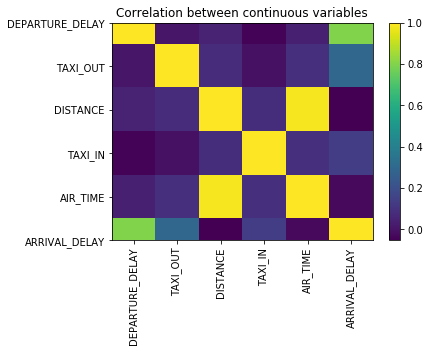

In [22]:
continuous_variables=['DEPARTURE_DELAY','TAXI_OUT','DISTANCE','TAXI_IN','AIR_TIME','ARRIVAL_DELAY']
cor_mat = ndf[continuous_variables].corr()

plt.imshow(cor_mat)
plt.xticks(range(len(continuous_variables)),continuous_variables,rotation='vertical')
plt.yticks(range(len(continuous_variables)),continuous_variables)
plt.colorbar()
plt.title('Correlation between continuous variables')
plt.show()

Text(0, 0.5, 'Number of records')

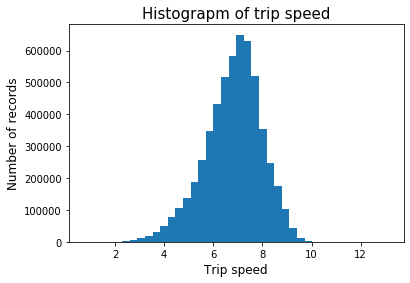

In [23]:
# 探索一下新来的attributes

plt.hist(ndf['trip_speed'],bins =40)
plt.title("Histograpm of trip speed",fontsize=15)     #trip speed 感觉是个normal distribution
                                                                     #把 distance 和 time 变成 speed 感觉不亏，美滋滋
plt.xlabel("Trip speed",fontsize=12)
plt.ylabel("Number of records",fontsize=12)

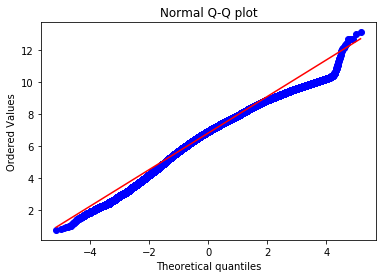

In [24]:
stats.probplot(ndf['trip_speed'], dist="norm", plot=plt)      # assume tip speed is normal distribution
plt.title("Normal Q-Q plot")
plt.show()

Text(0, 0.5, 'Mean value of delay')

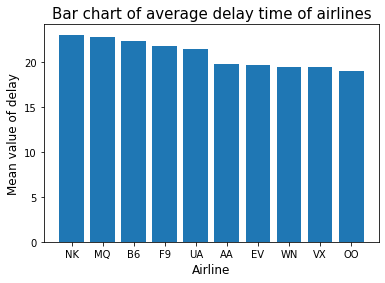

In [25]:
# 首先探索航线

s2 = po.groupby('AIRLINE').mean().ARRIVAL_DELAY   #延误 哪些航线比较猛 top10
ss = s2.sort_values(ascending=False)
label = list(ss.index)
x = list(ss)

plt.bar(x = label[0:10], height = x[0:10])
plt.title("Bar chart of average delay time of airlines",fontsize=15)     
plt.xlabel("Airline",fontsize=12)
plt.ylabel("Mean value of delay",fontsize=12)

(0, 23)

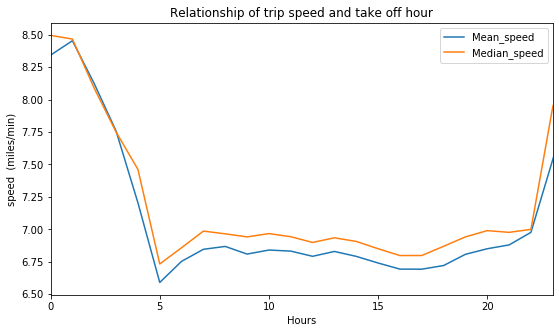

In [26]:
fig,ax = plt.subplots(1,1,figsize=(9,5)) # prepare fig to plot mean and median values
# use a pivot table to aggregate trip_speed by hour
table1 = ndf.pivot_table(index='take_off_hours', values='trip_speed',aggfunc=('mean','median')).reset_index()

# rename columns
table1.columns = ['Hour','Mean_speed','Median_speed']
table1[['Mean_speed','Median_speed']].plot(ax=ax)
plt.ylabel('speed  (miles/min)')
plt.xlabel('Hours')
plt.title('Relationship of trip speed and take off hour')
plt.xlim([0,23])

(0, 23)

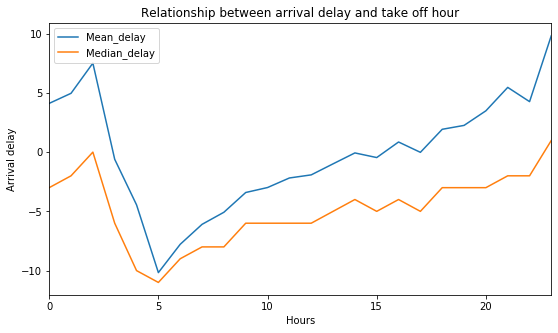

In [27]:
fig,ax = plt.subplots(1,1,figsize=(9,5)) # prepare fig to plot mean and median values
# use a pivot table to aggregate delay by hour
table1 = ndf.pivot_table(index='take_off_hours', values='ARRIVAL_DELAY',aggfunc=('mean','median')).reset_index()

# rename columns
table1.columns = ['Hour','Mean_delay','Median_delay']
table1[['Mean_delay','Median_delay']].plot(ax=ax)
plt.ylabel('Arrival delay')
plt.xlabel('Hours')
plt.title('Relationship between arrival delay and take off hour')
plt.xlim([0,23])

Text(0, 0.5, 'Mean value')

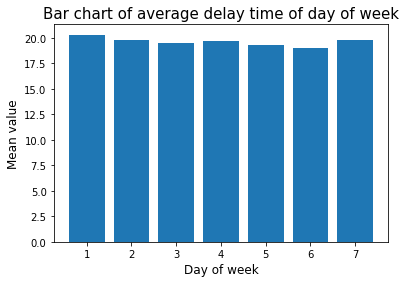

In [28]:
s2 = po.groupby('DAY_OF_WEEK').mean().ARRIVAL_DELAY  # 每天的mean value好像也都是一样的   和今天是周几并没有什么关系
labels=s2.index
plt.bar(x = labels, height = s2)
plt.title("Bar chart of average delay time of day of week",fontsize=15)     
plt.xlabel("Day of week",fontsize=12)
plt.ylabel("Mean value",fontsize=12)

Text(0, 0.5, 'Mean value')

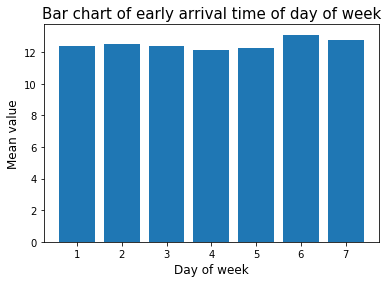

In [29]:
s2 = abs(ne.groupby('DAY_OF_WEEK').mean().ARRIVAL_DELAY)  # 每天的mean value好像也都是一样的   和今天是周几并没有什么关系
labels=s2.index
plt.bar(x = labels, height = s2)
plt.title("Bar chart of early arrival time of day of week",fontsize=15)     
plt.xlabel("Day of week",fontsize=12)
plt.ylabel("Mean value",fontsize=12)

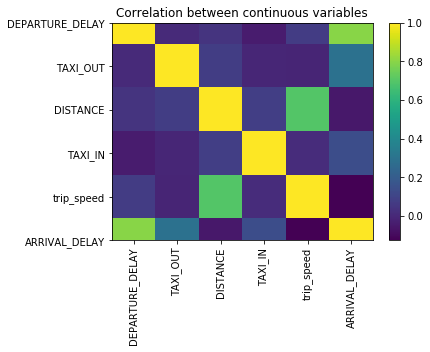

In [30]:
continuous_variables=['DEPARTURE_DELAY','TAXI_OUT','DISTANCE','TAXI_IN','trip_speed','ARRIVAL_DELAY']
cor_mat = ndf[continuous_variables].corr()

plt.imshow(cor_mat)
plt.xticks(range(len(continuous_variables)),continuous_variables,rotation='vertical')
plt.yticks(range(len(continuous_variables)),continuous_variables)
plt.colorbar()
plt.title('Correlation between continuous variables')
plt.show()

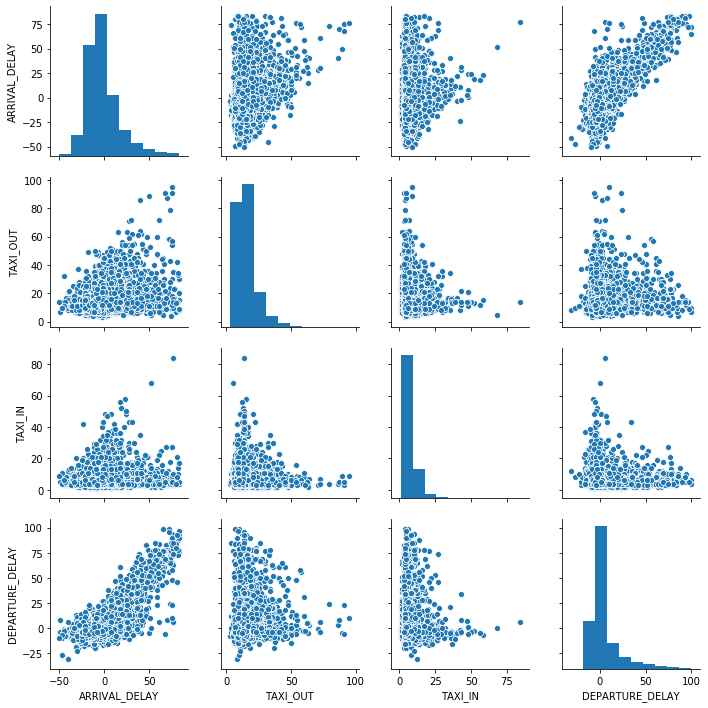

In [31]:
d2 = ndf.loc[:,['ARRIVAL_DELAY','TAXI_OUT','TAXI_IN','DEPARTURE_DELAY']].copy()
df2 = d2.sample(n=5000,random_state=59,axis=0)
sns.pairplot(df2)

Text(0, 0.5, 'Number of records')

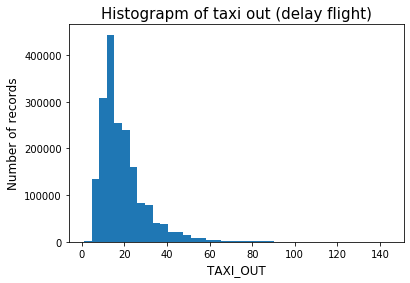

In [32]:
plt.hist(po['TAXI_OUT'],bins =40)
plt.title("Histograpm of taxi out (delay flight)",fontsize=15)    
                                                                     
plt.xlabel('TAXI_OUT',fontsize=12)
plt.ylabel("Number of records",fontsize=12)

Text(0, 0.5, 'Number of records')

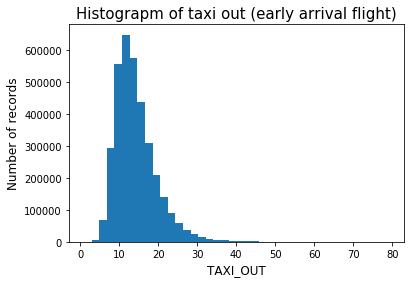

In [33]:
plt.hist(ne['TAXI_OUT'],bins =40)
plt.title("Histograpm of taxi out (early arrival flight)",fontsize=15)    
                                                                     
plt.xlabel('TAXI_OUT',fontsize=12)
plt.ylabel("Number of records",fontsize=12)

In [11]:
#df = ndf.loc[:,['SCHEDULED_DEPARTURE','DEPARTURE_DELAY','DEPARTURE_TIME',
#                    'TAXI_OUT','DISTANCE','TAXI_IN','trip_speed','take_off_hours']].copy()


#y = ndf.delay

#d_train,d_test,y_train,y_test = train_test_split(df,y,test_size = 0.3,random_state = 42)

In [34]:
df = ndf.sample(n=500000,random_state=59,axis=0)
y2 = df.delay
f_data2 = df.loc[:,['SCHEDULED_DEPARTURE','DEPARTURE_DELAY','DEPARTURE_TIME',
                    'TAXI_OUT','DISTANCE','TAXI_IN','trip_speed','take_off_hours']].copy()
d_train2,d_test2,y_train2,y_test2 = train_test_split(f_data2,y2,test_size = 0.3,random_state = 42)



## GNB

In [35]:
data.shape

(5819079, 31)

In [36]:
gnb = GNB().fit(d_train2,y_train2)
gnb.score(d_train2,y_train2),gnb.score(d_test2,y_test2)

(0.8386371428571429, 0.83976)

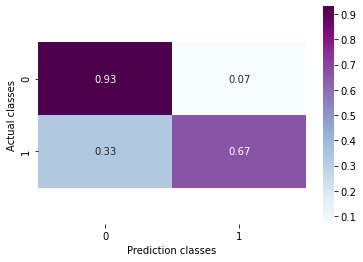

In [37]:
gnbl = gnb.predict(d_test2)
marix_GNB = confusion_matrix(y_test2,gnbl)

normed_matrix = normalize(marix_GNB, axis=1, norm='l1') # normalize the matrix
sns.heatmap(normed_matrix, annot = True,xticklabels = ['0','1'],yticklabels = ['0','1'],cmap = 'BuPu')
plt.xlabel('Prediction classes')
plt.ylabel('Actual classes')
b,t = plt.ylim()       # change the height of top and bottom 
b = b+0.5 
t = t-0.5
plt.ylim(b,t)
plt.show()  

## SVM

## after feature seledction 

In [29]:
df.shape

(500000, 26)

In [28]:
# svm-feature selection
#df2 = ndf.sample(n=100000,random_state=59,axis=0)


df2 = ndf.sample(n=100000,random_state=59,axis=0)

y = df2.delay
df2 = df.loc[:,['DEPARTURE_DELAY','TAXI_OUT','TAXI_IN','take_off_hours','trip_speed','DISTANCE']].copy()

d_trains,d_tests,y_trains,y_tests = train_test_split(df2,y,test_size = 0.3,random_state = 42)

ValueError: Found input variables with inconsistent numbers of samples: [500000, 100000]

0.8398485714285714 0.8410866666666666


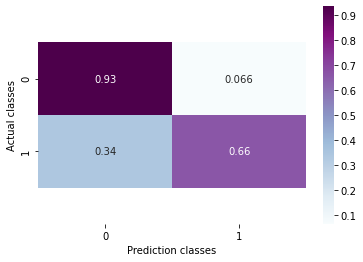

In [27]:
gnb = GNB().fit(d_trains,y_trains)
print(gnb.score(d_trains,y_trains),gnb.score(d_tests,y_tests))

gnb2 = gnb.predict(d_tests)
marix_GNB = confusion_matrix(y_tests,gnb2)

normed_matrix = normalize(marix_GNB, axis=1, norm='l1') # normalize the matrix
sns.heatmap(normed_matrix, annot = True,xticklabels = ['0','1'],yticklabels = ['0','1'],cmap = 'BuPu')
plt.xlabel('Prediction classes')
plt.ylabel('Actual classes')
b,t = plt.ylim()       # change the height of top and bottom 
b = b+0.5 
t = t-0.5
plt.ylim(b,t)
plt.show()  

## SVM

In [ ]:
svc = LinearSVC().fit(d_train2,y_train2)
cvscore(svc,d_train,y_train,cv = 3).mean(),svc.score(d_test2,y_test2)

In [154]:
svc1 = svc.predict(d_test2)
print(classification_report(y_test2,svc1))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88     98741
           1       0.85      0.60      0.71     51259

    accuracy                           0.83    150000
   macro avg       0.84      0.77      0.79    150000
weighted avg       0.83      0.83      0.82    150000



In [155]:
marix_svc = confusion_matrix(y_test2,svc1)
marix_svc

array([[93469,  5272],
       [20386, 30873]], dtype=int64)

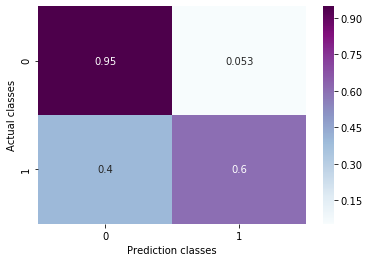

In [156]:
normed_matrix = normalize(marix_svc, axis=1, norm='l1') # normalize the matrix
sns.heatmap(normed_matrix, annot = True,xticklabels = ['0','1'],yticklabels = ['0','1'],cmap = 'BuPu')
plt.xlabel('Prediction classes')
plt.ylabel('Actual classes')
b,t = plt.ylim()       # change the height of top and bottom 
b = b+0.5 
t = t-0.5
plt.ylim(b,t)
plt.show()  

In [131]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression, mutual_info_regression

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k='all')
fit = bestfeatures.fit(d_train2,y_train2)
score = {'f':fit.scores_,'p':fit.pvalues_}
dfscores = pd.DataFrame(score,columns = ['f','p'])
dfcolumns = pd.DataFrame(d_train2.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','F-value','p-value']  #naming the dataframe columns
print(featureScores.nlargest(9,'F-value'))  #print 10 best features

                 Specs       F-value        p-value
2      DEPARTURE_DELAY  31931.207982   0.000000e+00
3             TAXI_OUT   6013.383508   0.000000e+00
7       take_off_hours   1634.760610   0.000000e+00
1       DEPARTURE_TIME   1531.711244   0.000000e+00
5              TAXI_IN   1304.675932  4.456298e-283
0  SCHEDULED_DEPARTURE   1058.174172  2.149868e-230
6           trip_speed    568.613570  3.560094e-125
4             DISTANCE      0.380450   5.373646e-01


In [ ]:
# feature selction 

In [14]:
# svm-feature selection
df2 = ndf.sample(n=100000,random_state=59,axis=0)
df2 = ndf.loc[:,['DEPARTURE_DELAY','TAXI_OUT','take_off_hours','DEPARTURE_TIME']].copy()
y = ndf.delay
d_trains,d_tests,y_trains,y_tests = train_test_split(df2,y,test_size = 0.3,random_state = 42)

In [15]:
svc = LinearSVC().fit(d_trains,y_trains)
cvscore(svc,d_trains,y_trains,cv = 3).mean(),svc.score(d_tests,y_tests)

svc1 = svc.predict(d_tests)
print(classification_report(y_tests,svc1))

marix_svc = confusion_matrix(y_tests,svc1)


normed_matrix = normalize(marix_svc, axis=1, norm='l1') # normalize the matrix
sns.heatmap(normed_matrix, annot = True,xticklabels = ['0','1'],yticklabels = ['0','1'],cmap = 'BuPu')
plt.xlabel('Prediction classes')
plt.ylabel('Actual classes')
b,t = plt.ylim()       # change the height of top and bottom 
b = b+0.5 
t = t-0.5
plt.ylim(b,t)
plt.show()  

/Users/wj7/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


KeyboardInterrupt: 